## Getting Kaggle NAR Dataset (You need to run it once for a single runtime)

In [ ]:
!pip install -q --upgrade --force-reinstall --no-deps kaggle

In [ ]:
# from google.colab import files
# files.upload()

{}

In [ ]:
!mkdir /root/.kaggle
!mv ./kaggle.json /root/.kaggle/.
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list --user gmshroff

ref                       title                     size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------  -----------------------  -----  -------------------  -------------  ---------  ---------------  
gmshroff/market-data      Market Data               39MB  2022-02-07 11:11:00             22          1  0.125            
gmshroff/market-data-cl   Market Data CL           404MB  2022-02-11 12:24:49              1          1  0.23529412       
gmshroff/few-shot-nar     Few-shot version of NAR  370MB  2022-02-01 09:29:05             15          0  0.3125           
gmshroff/few-shot-arc     Few-shot version of ARC  609KB  2022-02-14 11:03:57             27          0  0.25             
gmshroff/options-dataset  Options Dataset          151MB  2022-02-07 17:01:18              3          0  0.0              


In [ ]:
!kaggle datasets download -d gmshroff/few-shot-nar

 98% 362M/370M [00:04<00:00, 124MB/s]
100% 370M/370M [00:04<00:00, 79.7MB/s]


In [ ]:
!unzip -q few-shot-nar.zip

In [ ]:
!ls

CNP.ipynb	  models.ipynb				 problems_10k.json
drive		  nar_classification_dataset_images_10k  sample_data
few-shot-nar.zip  nar_classification_dataset_images_2k	 utils.ipynb


In [ ]:
from matplotlib import pyplot as plt
import numpy as np

## AnalogicalReasoningDataset

In [ ]:
import json
import pathlib
from collections import namedtuple

import torch
from torchvision.io import read_image as tv_read_image
from torchvision import transforms

from PIL import Image

# def read_image(path):
#     return tv_read_image(str(path))
def read_image(path):
    return transforms.ToTensor()(Image.open(str(path)))

Example = namedtuple('Example', ['input', 'options', 'solution'])
Problem = namedtuple('Problem', ['examples', 'query', 'query_options', 'solution', 'program'])

class AnalogicalReasoningDataset(torch.utils.data.Dataset):
    """Analogical Reasoning Classification Dataset

    This dataset consists of analogical reasoning [1] classification problems.
    Each problem is made up of 5 parts
        1. Examples: a list of examples of a program where each example 
        is a tuple made of -
            i. Input image
            ii. Options for the output image among which one is the correct answer
            iii. The index of the correct option 
        2. Query: the query image for which to predict the correct option
        when the program (which should be inferred from the examples) is applied
        3. Query Options: the options for the output when the program inferred
        from the the examples is applied to the query
        4. Solution: the index of the correct option 
        5. Program: the ground truth program that generated the query image
    
    Calling `__getitem__` on this dataset returns a tuple containing 
        1. The problem with symbolic descriptions of the images
        2. The problem with images themselves
    Each of the above is a namedtuple with the following fields:
        1. `examples`: a list of examples of a program where each example
        is a tuple made of `input`, `options`, and `solution`.
        2. `query`
        3. `query_options`
        4. `solution`
        5. `program`
    Since this is a named tuple you can access these fields using their names.
    For example `problem.examples[0].input`

    This can be considered as a meta learning [2] task where each task consits 
    of training data (examples) and test data (query). You can split this dataset
    into meta-training and meta-test subsets. The meta-training subset can be
    used to train your model to be able to solve the query task given the examples.
    The meta-test subset can be used to test your model's performance.

    Args:
        problems_file: path to a json file containing the problems
        image_dir: path to the directory containing the images
        size (int): size of the dataset (should be given in the name of image_dir)

    References:
        [1] https://arxiv.org/abs/2111.10361
        [2] https://lilianweng.github.io/lil-log/2018/11/30/meta-learning.html#define-the-meta-learning-problem
    """
    def __init__(self, problems_file, image_dir, size1,size2):
        self.problems_file = problems_file
        self.image_dir = pathlib.Path(image_dir)
        self.size = size2-size1

        with open(self.problems_file, "r") as f:
            self.problems = json.load(f)[size1:size2]
        
    def __len__(self):
        return len(self.problems)

    def __getitem__(self, idx):
        problem = self.problems[idx]

        return Problem._make((
            [Example._make(e) for e in problem[0]],
            problem[1],
            problem[2],
            problem[3],
            problem[4],
        )), Problem._make((
            [
                Example._make((
                    read_image(self.image_dir/f"{idx}_{eidx}_input.png"),
                    [
                        read_image(self.image_dir/f"{idx}_{eidx}_{oidx}_option.png")
                        for oidx in range(len(problem[0][eidx][1]))
                    ],
                    problem[0][eidx][2]
                ))
                for eidx in range(len(problem[0]))
            ],
            read_image(self.image_dir/f"{idx}_query.png"),
            [
                read_image(self.image_dir/f"{idx}_{oidx}_query_option.png")
                for oidx in range(len(problem[2]))
            ],
            problem[3],
            problem[4]
        ))


## Extras

In [ ]:
narDS=AnalogicalReasoningDataset("./problems_10k.json","./nar_classification_dataset_images_10k/images_large",0,100)

In [ ]:
ex=narDS.__getitem__(1)

In [ ]:
[ex[1].examples[i].solution for i in range(len(ex[1].examples))]

[2, 1, 1, 0, 0, 2]

In [ ]:
np.array(ex[1].query).shape

(3, 64, 64)

In [ ]:
# plt.figure(figsize=(7,7))
# for i in range(6):
#   plt.subplot(6,1,i+1)
#   plt.imshow(np.array(ex[1].examples[i].input[0,:,:]))
#   plt.axis('off')

In [ ]:
# plt.figure(figsize=(4,4))
# j=5
# for i in range(4):
#   plt.subplot(1,4,i+1)
#   plt.imshow(np.array(ex[1].examples[j].options[i][0,:,:]))
#   plt.axis('off')
# print(f"Solution: {ex[1].examples[j].solution}")

So, each of the namedtuple ‘Problem’ is a task, and 
(Problem.examples.input, Problem.examples.solution)= (X_train,y_train)

and
(Problem.query, Problem.solution)=(X_test,y-test)


In [ ]:
#meta-train  train
print(f"No of meta-train train examples: {np.array(ex[1].examples).shape}")

#meta-train test  
print(f"No of meta-train test examples: {np.array(ex[1].query).shape}")

No of meta-train train examples: (6, 3)
No of meta-train test examples: (3, 64, 64)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


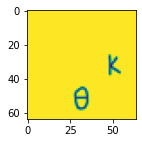

In [ ]:
# plt.imshow(np.array(ex[1].examples[1].input[0,:,:]))
plt.figure(figsize=(2,2))
plt.imshow(np.array(ex[1].query[0,:,:]))

Solution: 2


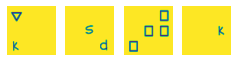

In [ ]:
plt.figure(figsize=(4,4))

for i in range(4):
  plt.subplot(1,4,i+1)
  plt.imshow(np.array(ex[1].query_options[i][0,:,:]))
  plt.axis('off')
print(f"Solution: {ex[1].solution}")

# plt.imshow(np.array(ex[1].query[0,:,:]))

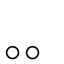

In [ ]:
transforms.ToPILImage()(ex[1].examples[2].options[ex[1].examples[2].solution])

In [ ]:
transforms.ToPILImage()(ex[1].examples[2].input)

In [ ]:
transforms.ToPILImage()(ex[1].examples[2].options[2])

In [ ]:
ex[1].examples[2].input.shape

In [ ]:
narDS.problems[0]


## Global Imports

In [ ]:
!pip install learn2learn --quiet

In [ ]:
!pip install import_ipynb --quiet

In [ ]:
import requests

In [ ]:
r=requests.get("https://github.com/gmshroff/metaLearning2022/blob/main/code/utils.ipynb?raw=true")
with open('./utils.ipynb','wb') as f: f.write(r.content)

In [ ]:
#Since we have to copy CNP and MAN and MAML for the experiments
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp drive/MyDrive/'Colab Notebooks'/'Meta_Learning_hw2'/models.ipynb .

In [ ]:
# from IPython import display
import torch
import import_ipynb
import utils
import models
from matplotlib import pyplot as plt
from IPython import display
import torch.nn as nn
from time import time
import torch.nn.functional as F

importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from models.ipynb


In [ ]:
ways=2
task_count=200

meta_train_size1 = 0
meta_train_size2 =task_count

meta_test_size1 = task_count
meta_test_size2 = 2*task_count

In [ ]:
#Getting a single task     
def get_task(ex):
  X_train = torch.stack([(ex[1].examples[i].input - ex[1].examples[i].options[j]).flatten() for i in range(len(ex[1].examples)) for j in range(len(ex[1].examples[i].options))])
  y_train = [F.one_hot(torch.tensor([ex[1].examples[i].solution]), num_classes=4) for i in range(len(ex[1].examples))]
  y_train =torch.stack(y_train).flatten() 

  X_test = torch.stack([(ex[1].query-ex[1].query_options[i]).flatten() for i in range(len(ex[1].query_options))  ])
  y_test = F.one_hot(torch.tensor(ex[1].solution), num_classes=len(ex[1].query_options))

  d_train=(X_train, y_train)
  d_test=(X_test, y_test)
  return d_train, d_test


# def get_task(ex):
#   # num of train options and num of test options are same i.e., 
#   num_options = len(ex[1].query_options)
#   num_examples = len(ex[1].examples)

#   X_train = torch.stack([(ex[1].examples[i].input - ex[1].examples[i].options[j]).flatten(num_examples) for i in range(num_examples) for j in range(num_options)])
#   y_train = [F.one_hot(torch.tensor([ex[1].examples[i].solution]), num_classes=num_options) for i in range(num_examples)]
#   y_train =torch.stack(y_train).flatten() 

#   X_test = torch.stack([(ex[1].query-ex[1].query_options[i]).flatten() for i in range(num_options)])
#   y_test = F.one_hot(torch.tensor(ex[1].solution), num_classes=num_options)

#   d_train=(X_train, y_train)
#   d_test=(X_test, y_test)
#   return d_train, d_test

# Redifning accuracy function so that it takes h - dataset context - as input since net requires it.
def accuracy(Net,X_test,y_test,h,verbose=True):
    #Net.eval()
    m = X_test.shape[0]
    y_pred = Net(X_test,h)
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_test).float().sum().item()
    if verbose: print(correct,m)
    accuracy = correct/m
    #Net.train()
    return accuracy


## CNP 

In [ ]:
!cp drive/MyDrive/'Colab Notebooks'/'Meta_Learning_hw2'/CNP.ipynb .

In [ ]:
from CNP import CNP

importing Jupyter notebook from CNP.ipynb


In [ ]:
# len(ex[1].examples[1].options)
# d_train, d_test = get_task(ex)
# p = [i-j for j in range(3) for i in range(6)]

# y_train = [F.one_hot(torch.tensor([ex[1].examples[i].solution]), num_classes=4) for i in range(len(ex[1].examples))]
# y_train =torch.stack(y_train).flatten() 

# print(a)
# type(ex[1].examples[1].solution)
# ex[1].examples[0].input - ex[1].examples[0].options[0]

In [ ]:
net = CNP(n_features=3*64*64,dims=[32,64,32],n_classes=ways,lr=1e-4)
lossfn = torch.nn.NLLLoss()

In [ ]:
import numpy as np
epoch=0
n_epochs=50
start_time=time()
meta_train_narDS = AnalogicalReasoningDataset("./problems_10k.json","./nar_classification_dataset_images_10k/images_large", meta_train_size1, meta_train_size2)

while epoch<n_epochs:
    test_loss = 0.0
    test_acc = 0.0
    # Sample and train on a task
    
    for task in range(task_count):
      '''
      d_train= (X_train, X_test)
      d_train[0] = X_train and d_train[0][0] is a tensor
      d_train[1] and d_train[1][0] is a tensor.
      
      d_train,d_test=meta_train_kloader.get_task()
      '''

      meta_train_NAR = meta_train_narDS.__getitem__(task)
      d_train,d_test=get_task(meta_train_NAR)
      
      rp = torch.randperm(d_train[1].shape[0])
      d_train0=d_train[0][rp]
      d_train1=d_train[1][rp]
      x_tr = d_train0
      d_tr = x_tr 
      h= net.adapt(d_tr,d_train1)

      rp1 = torch.randperm(d_test[1].shape[0])
      d_test0=d_test[0][rp1]
      d_test1=d_test[1][rp1]
      x_ts = d_test0
      y_ts_sh = torch.zeros(x_ts.shape[0],ways)
      d_ts = x_ts 

      test_preds = net(d_ts,h)
      
      # Accumulate losses over tasks - note train and test loss both included
      test_loss += lossfn(test_preds,d_test1)#+lossfn(train_preds,d_train1)
      net.eval()
      test_acc += accuracy(net,d_ts,d_test1,h,verbose=False)
      net.train()
      
    #Update the network weights
    print('Epoch  % 2d Loss: %2.5e Avg Acc: %2.5f'%(epoch,test_loss/task_count,test_acc/task_count))
    display.clear_output(wait=True)
    net.optimizer.zero_grad()
    test_loss.backward()
    net.optimizer.step()
    epoch+=1
time_taken=time()-start_time 

Epoch   49 Loss: 5.93439e-01 Avg Acc: 0.87750


In [ ]:
print(f"Time taken for {n_epochs} is: ", np.round(time_taken,3))

Time taken for 50 is:  186.371


In [ ]:
test_acc = 0.0
adapt_steps = 1
#set the size1 and size2 according to the indices for meta_train_narDS whether you want overlapping or non-overlapping
meta_test_narDS = AnalogicalReasoningDataset("./problems_10k.json","./nar_classification_dataset_images_10k/images_large", meta_test_size1, meta_test_size2)

# Sample and train on a task
for task in range(task_count):
    # d_train,d_test=meta_test_kloader.get_task()

    meta_test_NAR = meta_test_narDS.__getitem__(task)
    d_train, d_test = get_task(meta_test_NAR)
    x_tr = d_train[0]
    y_tr_sh = torch.cat((torch.zeros(1,ways),torch.eye(ways)[d_train[1][1:]]))
    d_tr = x_tr #torch.cat((x_tr,y_tr_sh),1)
    h=net.adapt(d_tr,d_train[1])
    x_ts = d_test[0]
    y_ts_sh = torch.zeros(x_ts.shape[0],ways)
    d_ts = x_ts #torch.cat((x_ts,y_ts_sh),1)
    test_preds = net(d_ts,h)
    test_acc += accuracy(net,d_ts,d_test[1],h,verbose=False)
    # Done with a task
net.train()
print('Avg Acc: %2.5f'%(test_acc/task_count))

Avg Acc: 0.63875


## MAN

In [ ]:
!cp drive/MyDrive/'Colab Notebooks'/'Meta_Learning_hw2'/MAN.ipynb .


In [4]:
import import_ipynb
# from Meta_Learning_hw2.MAN import MAN 


ImportError: cannot import name 'MAN' from 'Meta_Learning_hw2.MAN' (/Users/sweta/Desktop/xxxxxxxx/IIT_delhi/SEMESTER_2/Meta_Learning/assignment3/Assignment3_Meta_Learning_AIZ218356/Meta_Learning_hw2/MAN.ipynb)

In [ ]:
net = MAN(dims=[3*64*64,64,32],n_classes=ways,lr=1e-4)
lossfn = torch.nn.NLLLoss()

In [ ]:
from time import time
import numpy as np
epoch=0
n_epochs=50
start_time=time()
meta_train_narDS = AnalogicalReasoningDataset("./problems_10k.json","./nar_classification_dataset_images_10k/images_large", meta_train_size1, meta_train_size2)

while epoch<n_epochs:
    test_loss = 0.0
    test_acc = 0.0
    # Sample and train on a task
    for task in range(task_count):
        meta_train_NAR = meta_train_narDS.__getitem__(task)
        d_train, d_test = get_task(meta_train_NAR)
        rp = torch.randperm(d_train[1].shape[0]) # 0 to 24 randomly permuted d_train[1].shape=25
        d_train0=d_train[0][rp]
        d_train1=d_train[1][rp]
        x_tr = d_train0
        d_tr = x_tr 
        rp1 = torch.randperm(d_test[1].shape[0]) # 0 to 24 randomly permuted d_train[1].shape=25
        d_test0=d_test[0][rp1]
        d_test1=d_test[1][rp1]
        x_ts = d_test0
        d_ts = x_ts 
        test_preds = net(d_ts,(x_tr,d_train1))
        #train_preds = net(d_tr,h)
        # Accumulate losses over tasks - note train and test loss both included
        test_loss += lossfn(test_preds,d_test1)
        net.eval() #to activate the evaluation mode
        test_acc += accuracy(net,d_ts,d_test1,(x_tr,d_train1),verbose=False)
        net.train() #to activate the train mode
    
    #Update the network weights
    print('Epoch % 2d Loss: %2.5e Avg Acc: %2.5f'%(epoch,test_loss/task_count,test_acc/task_count))
    display.clear_output(wait=True)
    net.optimizer.zero_grad()
    test_loss.backward()
    net.optimizer.step()
    epoch+=1

time_taken=time()-start_time 

Epoch  49 Loss: -7.75804e-01 Avg Acc: 0.88625


In [ ]:
print(f"Time taken for {n_epochs} is: ", np.round(time_taken,3))

Time taken for 50 is:  224.867


In [ ]:
test_acc = 0.0
adapt_steps = 1
meta_test_narDS = AnalogicalReasoningDataset("./problems_10k.json","./nar_classification_dataset_images_10k/images_large", meta_test_size1, meta_test_size2)


# Sample and train on a task
for task in range(task_count):
    meta_test_NAR = meta_test_narDS.__getitem__(task)
    d_train, d_test = get_task(meta_test_NAR)
    
    x_tr = d_train[0]
    y_tr_sh = torch.cat((torch.zeros(1,ways),torch.eye(ways)[d_train[1][1:]]))
    d_tr = x_tr #torch.cat((x_tr,y_tr_sh),1)
    x_ts = d_test[0]
    y_ts_sh = torch.zeros(x_ts.shape[0],ways)
    d_ts = x_ts #torch.cat((x_ts,y_ts_sh),1)
    test_preds = net(d_ts,(d_tr,d_train[1]))
    net.eval()
    test_acc += accuracy(net,d_ts,d_test[1],(d_tr,d_train[1]),verbose=False)
    # Done with a task
    net.train()
print('Avg Acc: %2.5f'%(test_acc/task_count))

Avg Acc: 0.75000


## MAML


In [ ]:
import learn2learn as l2l
import torch.optim as optim
import models

net = models.MLP(dims=[3*64*64,32,32,ways])
maml = l2l.algorithms.MAML(net, lr=5e-3)
optimizer = optim.Adam(maml.parameters(),lr=5e-4)
lossfn = torch.nn.NLLLoss()


In [ ]:
import numpy as np
from time import time
# Number of epochs, tasks per step and number of fast_adaptation steps 
epoch=0
n_epochs=30
fas = 5
meta_train_narDS = AnalogicalReasoningDataset("./problems_10k.json","./nar_classification_dataset_images_10k/images_large",meta_train_size1,meta_train_size2)

start_time=time()

while epoch<n_epochs:
    adapt_loss = 0.0
    test_acc = 0.0
    # Sample and train on a task
    for task in range(task_count):
        meta_train_NAR = meta_train_narDS.__getitem__(task)
        d_train, d_test = get_task(meta_train_NAR)
        learner = maml.clone()
        for fas_step in range(fas):
            train_preds = learner(d_train[0])
            train_loss = lossfn(train_preds,d_train[1])
            learner.adapt(train_loss)
        test_preds = learner(d_test[0])
        adapt_loss += lossfn(test_preds,d_test[1])
        learner.eval()
        test_acc += models.accuracy(learner,d_test[0],d_test[1],verbose=False)
        learner.train()
        # Done with a task
    # Update main network
    print('Epoch  % 2d Loss: %2.5e Avg Acc: %2.5f'%(epoch,adapt_loss/task_count,test_acc/task_count))
    display.clear_output(wait=True)
    optimizer.zero_grad()
    total_loss = adapt_loss
    total_loss.backward()
    optimizer.step()
    epoch+=1
time_taken=time()-start_time 


Epoch   29 Loss: 3.34068e-01 Avg Acc: 0.89625


In [ ]:
print(f"Time taken for {n_epochs} is: ", np.round(time_taken,3))

Time taken for 30 is:  236.25


In [ ]:
test_acc = 0.0
adapt_steps = 5
meta_test_narDS = AnalogicalReasoningDataset("./problems_10k.json","./nar_classification_dataset_images_10k/images_large",meta_test_size1, meta_test_size2)

maml.eval()
# Sample and train on a task
for task in range(task_count):
    meta_test_NAR = meta_test_narDS.__getitem__(task)
    d_train, d_test = get_task(meta_test_NAR)
    learner = maml.clone()
    learner.eval()
    for adapt_step in range(adapt_steps):
        train_preds = learner(d_train[0])
        train_loss = lossfn(train_preds,d_train[1])
        learner.adapt(train_loss)
    test_preds = learner(d_test[0])
    test_acc += models.accuracy(learner,d_test[0],d_test[1],verbose=False)
    # Done with a task
#learner.train()
print('Avg Acc: %2.5f'%(test_acc/task_count))

Avg Acc: 0.65000


## Plotting Graphs

Text(0.5, 1.0, 'CNP Model(num epochs=50)')

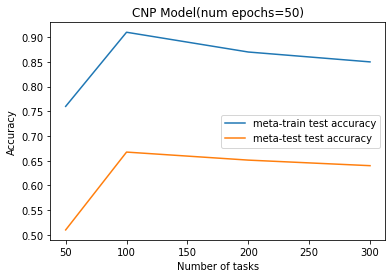

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# #Plot
# x=[50,100, 200, 300]
# y1=[0.76, 0.91, 0.87, 0.85]
# y2=[0.51, 0.66750, 0.65125, 0.64]
# # plt.xlim([45,305])
# plt.plot(x,y1)
# plt.plot(x,y2)
# plt.legend(['meta-train test accuracy','meta-test test accuracy'] , loc ="center right")
# plt.xlabel("Number of tasks")
# plt.ylabel("Accuracy")
# plt.title("CNP Model(num epochs=50)")

Text(0.5, 1.0, 'MAN Model(num_epochs=50)')

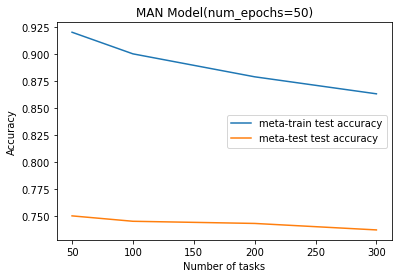

In [ ]:
# x=[50,100, 200, 300]
# y1=[0.92, 0.9, 0.87875, 0.863]
# y2=[0.75, 0.745, 0.743,0.737]
# plt.plot(x,y1)
# plt.plot(x,y2)
# plt.legend(['meta-train test accuracy','meta-test test accuracy'] , loc ="center right")
# plt.xlabel("Number of tasks")
# plt.ylabel("Accuracy")
# plt.title("MAN Model(num_epochs=50)")

Text(0.5, 1.0, 'MAML Model (num_epochs=30)')

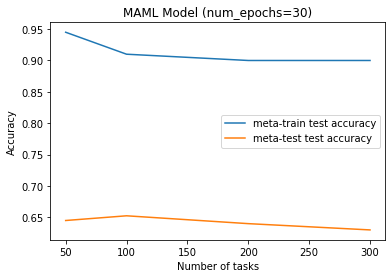

In [ ]:
# x=[50,100, 200, 300]
# y1=[0.945, 0.91, 0.9, 0.9]
# y2=[0.645, 0.65250, 0.64, 0.63]

# plt.plot(x,y1)
# plt.plot(x,y2)
# plt.legend(['meta-train test accuracy','meta-test test accuracy'] , loc ="center right")
# plt.xlabel("Number of tasks")
# plt.ylabel("Accuracy")
# plt.title("MAML Model (num_epochs=30)")

Text(0.5, 1.0, 'Comparison of accuracy across Models (num_epochs=(50,50,30))')

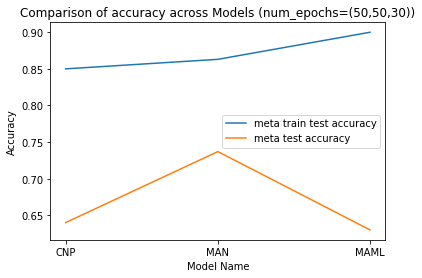

In [ ]:
# x=["CNP","MAN","MAML"]
# y1=[0.85, 0.863, 0.9]
# y2=[0.64, 0.737, 0.63]

# plt.plot(x,y1)
# plt.plot(x,y2)
# plt.legend(['meta train test accuracy','meta test accuracy'] , loc ="center right")
# plt.xlabel("Model Name")
# plt.ylabel("Accuracy")
# plt.title("Comparison of accuracy across Models (num_epochs=(50,50,30))")